In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(theme='ggplot',sharing='public',offline=True)
from IPython.display import display,HTML

In [3]:
pd.set_option('display.max_columns',10)
df = pd.read_excel('data/Metallolom.xlsx', 'Sheet3', parse_dates=True,index=['time'])
print(df.head(20))
print(df.columns)

                  time  Median
0  2013-01-03 20:00:00  8440.0
1  2013-01-10 20:00:00  8305.0
2  2013-01-17 20:00:00  8335.0
3  2013-01-24 20:00:00  8375.0
4  2013-01-31 20:00:00  8115.0
5  2013-02-07 20:00:00  8505.0
6  2013-02-14 20:00:00  8485.0
7  2013-02-21 20:00:00  8430.0
8  2013-02-28 20:00:00  8395.0
9  2013-03-07 20:00:00  8760.0
10 2013-03-14 20:00:00  8760.0
11 2013-03-21 20:00:00  8790.0
12 2013-03-28 20:00:00  8940.0
13 2013-04-04 20:00:00  9010.0
14 2013-04-11 20:00:00  9150.0
15 2013-04-18 20:00:00  8970.0
16 2013-04-25 20:00:00  9150.0
17 2013-05-02 20:00:00  9040.0
18 2013-05-09 20:00:00  9025.0
19 2013-05-16 20:00:00  8965.0
Index(['time', 'Median'], dtype='object')


In [42]:
df = df.drop(['price_1','name_2','name_4','name_5','name_6',
               'name_7','name_8','name_9'],axis=1)
df.head()

,time,Median
0,2013-01-03 20:00:00,8440.0
1,2013-01-10 20:00:00,8305.0
2,2013-01-17 20:00:00,8335.0
3,2013-01-24 20:00:00,8375.0
4,2013-01-31 20:00:00,8115.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 2 columns):
time      374 non-null datetime64[ns]
Median    355 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.0 KB


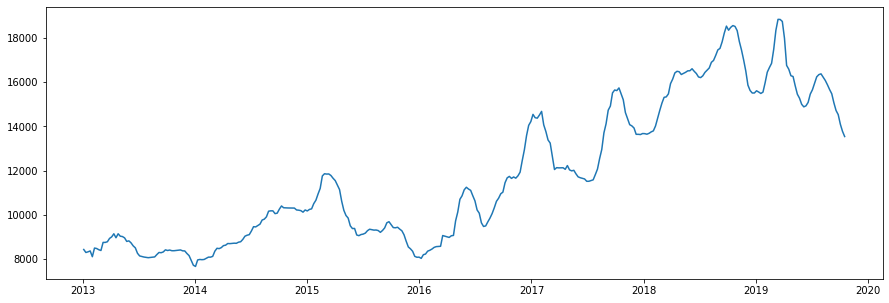

In [5]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(15,5))
plt.plot(df.time, df.Median)

In [6]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.utilities.dataframe_functions import roll_time_series


# Fix needed to pandas datareader
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [7]:
df.shape

(374, 2)

In [8]:
df_shift, y = make_forecasting_frame(df.Median, kind="price", max_timeshift=52, rolling_direction=1)

In [9]:
df_shift.shape

(17880, 4)

In [10]:
y.shape

(373,)

In [11]:
df_shift.tail(20)

,time,value,id,kind
4598,334.0,14995.0,373,price
4934,335.0,14880.0,373,price
5271,336.0,14925.0,373,price
5609,337.0,15080.0,373,price
5948,338.0,15455.0,373,price
6288,339.0,15650.0,373,price
6629,340.0,15940.0,373,price
6971,341.0,16235.0,373,price
7314,342.0,16335.0,373,price
7658,343.0,16370.0,373,price


In [12]:
%%capture
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute,
                     show_warnings=False)

 'value__fft_coefficient__coeff_27__attr_"angle"'
 'value__fft_coefficient__coeff_27__attr_"imag"'
 'value__fft_coefficient__coeff_27__attr_"real"'
 'value__fft_coefficient__coeff_28__attr_"abs"'
 'value__fft_coefficient__coeff_28__attr_"angle"'
 'value__fft_coefficient__coeff_28__attr_"imag"'
 'value__fft_coefficient__coeff_28__attr_"real"'
 'value__fft_coefficient__coeff_29__attr_"abs"'
 'value__fft_coefficient__coeff_29__attr_"angle"'
 'value__fft_coefficient__coeff_29__attr_"imag"'
 'value__fft_coefficient__coeff_29__attr_"real"'
 'value__fft_coefficient__coeff_30__attr_"abs"'
 'value__fft_coefficient__coeff_30__attr_"angle"'
 'value__fft_coefficient__coeff_30__attr_"imag"'
 'value__fft_coefficient__coeff_30__attr_"real"'
 'value__fft_coefficient__coeff_31__attr_"abs"'
 'value__fft_coefficient__coeff_31__attr_"angle"'
 'value__fft_coefficient__coeff_31__attr_"imag"'
 'value__fft_coefficient__coeff_31__attr_"real"'
 'value__fft_coefficient__coeff_32__attr_"abs"'
 'value__fft_coeffic

In [23]:
X.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40",...,value__value_count__value_-1,value__value_count__value_0,value__value_count__value_1,value__variance,value__variance_larger_than_standard_deviation
id,,,,,,,,,,,
1,71233600.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0000,0.0
2,140206625.0,135.0,-1.000000,-1.000000,0.000000,...,0.0,0.0,0.0,4556.2500,1.0
3,209678850.0,165.0,-0.524254,-0.524254,0.005294,...,0.0,0.0,0.0,3350.0000,1.0
4,279819475.0,205.0,-0.209650,-0.406320,0.152602,...,0.0,0.0,0.0,2554.6875,1.0
5,345672700.0,465.0,-0.503909,-0.156533,0.904281,...,0.0,0.0,0.0,11944.0000,1.0


In [13]:
X.shape

(373, 794)

In [14]:
# drop constant features
print(X.shape)
X = X.loc[:, X.apply(pd.Series.nunique) != 1] 
print(X.shape)

(373, 794)
(373, 429)


In [58]:
X.tail()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""__maxlag_40","value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__agg_autocorrelation__f_agg_""var""__maxlag_40",...,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__variance,value__variance_larger_than_standard_deviation,feature_last_value
id,,,,,,,,,,,
369,9.652033e+09,10895.0,-0.254064,-0.176046,0.376709,...,-1.263438e+11,-2.272243e+11,1.529554e+06,1.0,NaN
370,9.396992e+09,10420.0,-0.322068,-0.204697,0.455850,...,-1.565806e+11,-2.906834e+11,1.571530e+06,1.0,NaN
371,9.126554e+09,10210.0,-0.369378,-0.199457,0.570467,...,-1.972511e+11,-3.513041e+11,1.613086e+06,1.0,NaN
372,8.849165e+09,10020.0,-0.419209,-0.204596,0.733230,...,-2.487963e+11,-4.120397e+11,1.651136e+06,1.0,NaN
373,8.565411e+09,9385.0,-0.484319,-0.192029,0.999519,...,-3.020164e+11,-4.548664e+11,1.682976e+06,1.0,NaN


In [64]:
y.tail(20)

354    13540.0
355        NaN
356        NaN
357        NaN
358        NaN
359        NaN
360        NaN
361        NaN
362        NaN
363        NaN
364        NaN
365        NaN
366        NaN
367        NaN
368        NaN
369        NaN
370        NaN
371        NaN
372        NaN
373        NaN
Name: value, dtype: float64

In [15]:
y = y.fillna(0)
y.tail(20)

354    13540.0
355        0.0
356        0.0
357        0.0
358        0.0
359        0.0
360        0.0
361        0.0
362        0.0
363        0.0
364        0.0
365        0.0
366        0.0
367        0.0
368        0.0
369        0.0
370        0.0
371        0.0
372        0.0
373        0.0
Name: value, dtype: float64

In [16]:
# Add last value as feature
X["feature_last_value"] = y.shift(1)

In [17]:
# Drop first line
X = X.iloc[1:, ]
y = y.iloc[1: ]

In [84]:
ada = AdaBoostRegressor(n_estimators=10)
y_pred = [np.NaN] * len(y)

isp = 355   # index of where to start the predictions
assert isp > 0

for i in range(isp, len(y)):
    
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))[0]
    y[i-1] = y_pred[i]
    
y_pred = pd.Series(data=y_pred, index=y.index)

In [85]:
y_pred.tail(20)

354            NaN
355            NaN
356            NaN
357            NaN
358     152.922360
359    1070.456522
360      65.538154
361    1070.456522
362      18.725187
363      13.107631
364      13.107631
365      10.947032
366      21.065835
367      18.390809
368      66.370385
369      17.878095
370      66.370385
371      22.030674
372      66.037493
373      17.465409
dtype: float64

In [86]:
y.tail(20)

354     152.922360
355    1070.456522
356      65.538154
357    1070.456522
358      18.725187
359      13.107631
360      13.107631
361      10.947032
362      21.065835
363      18.390809
364      66.370385
365      17.878095
366      66.370385
367      22.030674
368      66.037493
369      17.465409
370       0.000000
371       0.000000
372       0.000000
373       0.000000
Name: value, dtype: float64

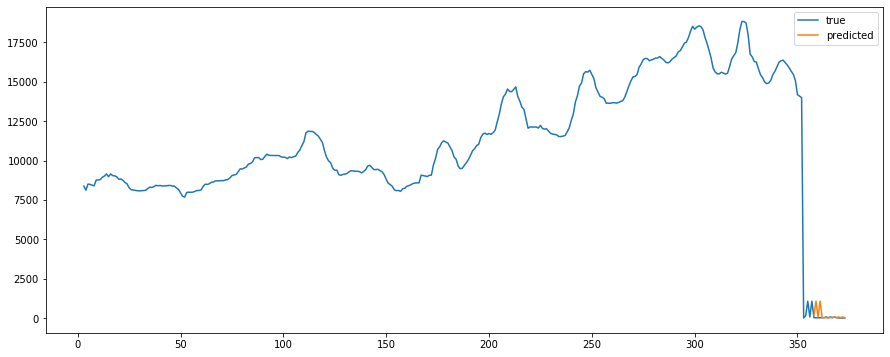

In [87]:
plt.figure(figsize=(15, 6))
plt.plot(y, label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

In [ ]:
ada = AdaBoostRegressor()
pred_n = 30
y_pred = [0] * len(y)
y_pred[0] = y.iloc[0]


for i in range(len(y)-pred_n, len(y)):
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))
    
y_pred = pd.Series(data=y_pred, index=y.index)

In [21]:
X_tr = X.iloc[:353]
X_test = X.iloc[353:]
y_tr = y.iloc[:353]
y_test = y.iloc[353:]
y_tr.tail()

350    14715.0
351    14530.0
352    14095.0
353    13775.0
354    13540.0
Name: value, dtype: float64

In [22]:
X_train = X_tr.iloc[:300]
X_val = X_tr.iloc[300:]
y_train = y_tr.iloc[:300]
y_val = y_tr.iloc[300:]

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [24]:
sc = StandardScaler()
rf = RandomForestRegressor()